In [126]:
from nufeb_tools import utils,plot
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.signal import find_peaks
from pathlib import Path
from joblib import Parallel, delayed
from tqdm import tqdm

In [127]:
low = utils.get_data(directory= r'D:\runs\sucrose-sweep\Run_50_50_10_1_2021-09-21_167923')
med = utils.get_data(directory= r'D:\runs\sucrose-sweep\Run_50_50_50_1_2021-09-21_660658')
high = utils.get_data(directory= r'D:\runs\sucrose-sweep\Run_50_50_100_1_2021-09-21_943999')

In [128]:
runs = [r'D:\runs\Run_50_50_100_1_2021-08-04_879890',
        r'D:\runs\Run_50_50_100_1_2021-08-04_749751',
        r'D:\runs\Run_50_50_100_1_2021-08-04_738274',
        r'D:\runs\Run_50_50_100_1_2021-08-04_594614',
        r'D:\runs\Run_50_50_100_1_2021-08-04_584010',
        r'D:\runs\Run_50_50_100_1_2021-08-04_548827',
        r'D:\runs\Run_50_50_100_1_2021-08-04_462847',
        r'D:\runs\Run_50_50_100_1_2021-08-04_369407',
        r'D:\runs\Run_50_50_100_1_2021-08-04_262947',
        r'D:\runs\Run_50_50_100_1_2021-08-04_174205'
        ]
def mu_sweep(folders):
    data = list()
    for folder in folders:
        data.append(utils.get_data(directory= folder))
    mus = list()
    mmu = list()
    for d in data:
        mus.append(d.metadata['ecw']['GrowthRate'])
        mmu.append(d.metadata['ecw']['GrowthRate']/d.metadata['cyano']['GrowthRate'])
    d2 = [x for _, x in sorted(zip(mus, data))]
    mu2 = sorted(mus)
    dmu = sorted(mmu)
    Ratio2 = [x.biomass.iloc[-1,2]/x.biomass.iloc[-1,1] for x in d2]
    return Ratio2, mu2, dmu
Ratio2, mu2, dmu = mu_sweep(runs)

In [129]:
Ratio = [x.biomass.iloc[-1,2]/x.biomass.iloc[-1,1] for x in [low,med,high]]
labels = ['low','med','high']
colors = ['#fee6ce','#fdae6b','#e6550d']
cons = [low,med,high]
ss_time = list()
suc_max = list()
suc_end = list()
for con in cons:
    difference = np.diff(con.avg_con['Sucrose'].values,prepend=0)
    ss_time.append(con.avg_con.index[np.argmin(difference)])
    suc_max.append(con.avg_con['Sucrose'].max())
    suc_end.append(con.avg_con['Sucrose'].iloc[-10:].mean())

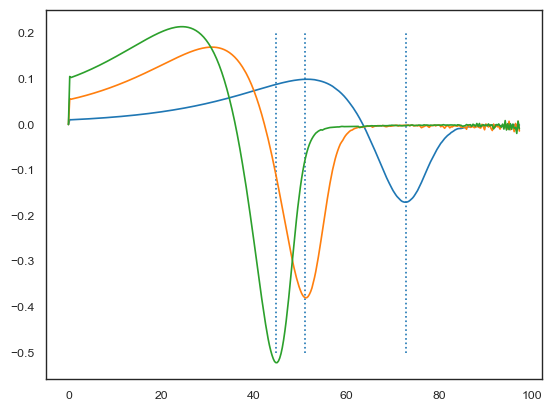

In [130]:
cons = [low,med,high]
ss_time = list()
suc_max = list()
suc_end = list()
f,ax = plt.subplots()
for con in cons:
    difference = np.diff(con.avg_con['Sucrose'].values,prepend=0)#np.diff(con.avg_con['Sucrose'],prepend=0,n=20)
    #pks,_ = find_peaks(difference,distance=50,height=.005)
    #idx = [con.avg_con.index[x] for x in pks]
    ax.plot(con.avg_con.index,difference)
    ax.vlines(con.avg_con.index[np.argmin(difference)],-0.5,0.2,ls=':')
    ss_time.append(con.avg_con.index[np.argmin(difference)])
    suc_max.append(con.avg_con['Sucrose'].max())
    suc_end.append(con.avg_con['Sucrose'].iloc[-10:].mean())
    #ax.scatter(idx,difference[pks])
#plot.average_nutrients(low.avg_con,'Sucrose',color='#fee6ce',ax=ax)
plt.show()

In [132]:
DIR = Path(f'D:/runs/sucrose-sweep')
folders = [path for path in DIR.iterdir() if path.is_dir()]
def get_biomass(folders):
    df = pd.DataFrame(columns=['Hours','cyano','ecw','sucRatio'])
    data = [ ]
    
    for folder in tqdm(sorted(folders)):
        x = utils.get_data(directory=str(folder))
        temp = x.biomass.reset_index()[['Hours','cyano','ecw']]
        temp.loc[:,'sucRatio'] = x.sucRatio
        df=df.append(temp,ignore_index=True)
    df.loc[:,'pop_ratio'] = df.ecw/df.cyano
    return df

In [133]:
df = get_biomass(folders)

100%|██████████| 50/50 [13:44<00:00, 16.48s/it]


In [136]:
DIR = Path(f'D:/runs/population-stability')
def population_stability(DIR):

    folders = [path for path in DIR.iterdir() if path.is_dir()]
    x= list()
    y = list()
    sucs = list()
    for folder in tqdm(sorted(folders)):
        temp = utils.get_data(directory=str(folder))
        x.append(temp.biomass.reset_index()['Hours'])
        y.append(temp.biomass['ecw']/temp.biomass['cyano'])
        sucs.append(temp.sucRatio)
    return x,y,sucs
x,y,sucs = population_stability(DIR)
sucroseRatios=sorted(list(set(sucs)))

100%|██████████| 35/35 [10:00<00:00, 17.17s/it]


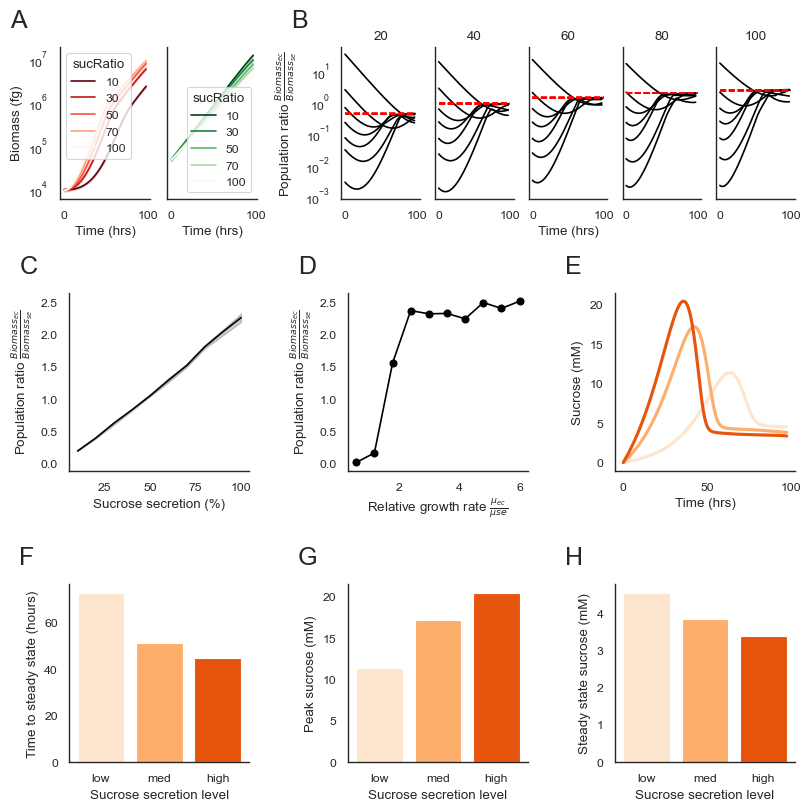

In [141]:
from matplotlib import transforms
fig = plt.figure(constrained_layout=True, figsize=(8,8))
widths = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
heights = [1, .75, .75]
def label_panel(ax, letter, *,
                offset_left=0.5, offset_up=0.2, prefix='', postfix='', **font_kwds):
    kwds = dict(fontsize=18)
    kwds.update(font_kwds)
    # this mad looking bit of code says that we should put the code offset a certain distance in
    # inches (using the fig.dpi_scale_trans transformation) from the top left of the frame
    # (which is (0, 1) in ax.transAxes transformation space)
    fig = ax.figure
    trans = ax.transAxes + transforms.ScaledTranslation(-offset_left, offset_up, fig.dpi_scale_trans)
    ax.text(0, 1, prefix+letter+postfix, transform=trans, **kwds)

def label_panels(axes, letters=None, **kwds):
    if letters is None:
        letters = axes.keys()
    for letter in letters:
        ax = axes[letter]
        label_panel(ax, letter, **kwds)


gs0 = gridspec.GridSpec(3, 15, figure=fig,wspace=.7,hspace=.1, width_ratios=widths,
                          height_ratios=heights)
sns.set_context('paper')
sns.set_style('white')


# Biomass vs time
#ax1 = fig.add_subplot(gs0[0, :4])
#ax1_2 = fig.add_subplot(gs0[0, 5:8],sharey=ax1)
gs00 = gs0[0,:5].subgridspec(1,2)
ax1=gs00.subplots(sharey=True)
sns.lineplot(x='Hours',y='ecw',hue='sucRatio',data=df[df.sucRatio.isin(ratios)],ci='sd',ax=ax1[0],palette='Reds_r')
sns.lineplot(x='Hours',y='cyano',hue='sucRatio',data=df[df.sucRatio.isin(ratios)],ci='sd',ax=ax1[1],palette='Greens_r')
ax1[0].set_yscale('log')
ax1[0].set_xlabel('Time (hrs)')
ax1[1].set_xlabel('Time (hrs)')
ax1[0].set_ylabel('Biomass (fg)')
#ax1[1].set_ylabel('')
#ax1[1].set_yticklabels('')

# Population stability dynamics
gs01 = gs0[0,5:].subgridspec(1,len(sucroseRatios))
#ax3 = fig.add_subplot(gs0[0, 2])

#ax3_1 = fig.add_subplot(gs01[0])
#ax3_2 = fig.add_subplot(gs01[1], sharey=ax3_1)
#ax3_3 = fig.add_subplot(gs01[2], sharey=ax3_1)
#ax3_4 = fig.add_subplot(gs01[3], sharey=ax3_1)
ax3=gs01.subplots(sharey=True)
for X,Y,S in zip(x,y,sucs):
    ax3[sucroseRatios.index(S)].plot(X,Y,c='k')
    ax3[sucroseRatios.index(S)].set_title(S)

for ax in ax3.ravel():
    ax.set_yscale('log')
ax3[0].set_ylabel(r'Population ratio $\frac{Biomass_{ec}}{Biomass_{se}}$')
ax3[2].set_xlabel('Time (hrs)')
for s in sucroseRatios:
    y_line = df.loc[(df.Hours==df.Hours.iloc[-1]) & (df.sucRatio == s),'pop_ratio']
    ax3[sucroseRatios.index(s)].plot([0,100], [y_line,y_line], color='red', linestyle='--')



# Population ratio vs sucrose secretion level
ax4 = fig.add_subplot(gs0[1, :5])
sns.lineplot(x='sucRatio',y='pop_ratio',data=df.loc[df.Hours==df.Hours.iloc[-1]],ax=ax4,color='k')
ax4.set_xlabel('Sucrose secretion (%)')
ax4.set_ylabel(r'Population ratio $\frac{Biomass_{ec}}{Biomass_{se}}$')

# Population ratio vs relative growth rate
ax5 = fig.add_subplot(gs0[1, 5:10],sharey=ax4)
ax5.plot(dmu,Ratio2,marker='o',color='k')
#ax4.set(yscale="log")
ax5.set_xlabel(r'Relative growth rate $\frac{\mu_{ec}}{\mu{se}}$')
ax5.set_ylabel(r'Population ratio $\frac{Biomass_{ec}}{Biomass_{se}}$')

# Sucrose over time
ax6 = fig.add_subplot(gs0[1, 10:])
plot.average_nutrients(low.avg_con,'Sucrose',color='#fee6ce',ax=ax6)
plot.average_nutrients(med.avg_con,'Sucrose',color='#fdae6b',ax=ax6)
plot.average_nutrients(high.avg_con,'Sucrose',color='#e6550d',ax=ax6)
ax6.set_ylabel('Sucrose (mM)')
ax6.set_xlabel('Time (hrs)')

sns.set_context('paper')
sns.set_style('white')
# Time to steady state
ax7 = fig.add_subplot(gs0[2, :5])
ax7.bar(labels,ss_time,color=colors)
ax7.set_xlabel('Sucrose secretion level')
ax7.set_ylabel('Time to steady state (hours)')

# Peak sucrose
ax8= fig.add_subplot(gs0[2, 5:10])
ax8.bar(labels,suc_max,color=colors)
ax8.set_xlabel('Sucrose secretion level')
ax8.set_ylabel('Peak sucrose (mM)')

# Steady state sucrose
ax9 = fig.add_subplot(gs0[2, 10:])
ax9.bar(labels,suc_end,color=colors)
ax9.set_xlabel('Sucrose secretion level')
ax9.set_ylabel('Steady state sucrose (mM)')

label_panel(ax1[0],'A')
label_panel(ax3[0],'B')
label_panel(ax4,'C')
label_panel(ax5,'D')
label_panel(ax6,'E')
label_panel(ax7,'F')
label_panel(ax8,'G')
label_panel(ax9,'H')
#label_panels(ax1[0],ax3[0],ax4,ax5,ax6,ax7,ax8,ax9, letters='ABCDEFGH')

sns.despine()
plt.show()
fig.savefig('../figures/Whole culture analysis V2.png',dpi=600)